<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Friends_logo.svg/1199px-Friends_logo.svg.png'>

# Friends Transcript Analysis

Data visualizations in Public Tableau: https://public.tableau.com/app/profile/idan.nisani/viz/FriendsAnalysis_16389855333420/ShareofLines?publish=yes

Friends is one of the most famous and successful TV shows ever created. Showing the daily struggles of a group of 6 young adults, Friends remains popular to this day.

In the following project I analyzed the full transcripts of around 200 episodes. The research goal is to understand better the characters and the relationships between the characters, based on what they said on the show.

I intend to address the following questions:
1. What are the characters most often speak about?
2. How strong are the relations between the characters?
3. Where do the characters spend most of their time?


The project will consist of four parts:
1. **Retrieving the data**: Transcripts to all episodes will be retrieved from the following website: https://fangj.github.io/friends/
2. **Data Preprocessing**: Each line in the transcript will be added to a dataframe that includes the line itself, the speaker and the episode it was taken from.
3. **Analysis**: I will analyze the data to answer the research questions.
4. **Data Presentation**: Results will be added to an interactive presentation using Tableau Public.


## Retrieving the Data

In this part, transcripts of all Friends episodes will be downloaded locally. I will use the following website, which I found using a simple Google search: https://fangj.github.io/friends/

I will first create a dictionary with all episodes and their links, then iterate through it and get each transcript.

In [1]:
## First, loading the required libraries

import pandas as pd
import requests
from bs4 import BeautifulSoup
import re
from collections import Counter
import numpy as np  

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
import plotly.express as px

import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

wordnet_lemma = WordNetLemmatizer() 

from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

from gensim.corpora import Dictionary
from gensim.models import TfidfModel

import gensim.downloader as api
from gensim.similarities import SparseTermSimilarityMatrix, WordEmbeddingSimilarityIndex

### Gathering Episodes List

In [2]:
## Preparing a request to the website: https://fangj.github.io/friends/
## In this page, there's a list of all Friends episodes

URL = 'https://fangj.github.io/friends/'
req = requests.get(URL)
soup = BeautifulSoup(req.text, 'lxml')

Using BeautifulSoup, we simply get all the links and storing them in a dictionary.

In [3]:
## Creating a dictionary with all episodes and their links

episodes_list = {}

## Adding all links in the page to the dictionary

for link in soup.find_all('a'):
    episodes_list[link.text] = link['href']

### Downloading Episodes Transcripts

Next, I will iterate through the items in the dictionary and get the transcript of each episode. The transcripts will be saved in a text file in their original HTML form.

Each text file will carry the name of the episode.

**Note**: Since this step should only be performed once, it will be commented out.

In [4]:
#for episode, episode_link in episodes_list.items():
#    try: 
#        ep_URL = URL+'/'+episode_link
#        req = requests.get(ep_URL)
#        f = open("Episodes/"+episode+".txt", "a")
#        f.write(req.text)
#        f.close()
#    except:
#        pass
#        f.close()

We now have all transcripts downloaded locally, and we can start working on how to transform them into a single dataframe.

### Retrieving the Lines

First, by going over some of the transcripts, we can see that director instructions to the actors were left in. See, for example, the following line of Monica:
**Monica**: (explaining to the others) Carol moved her stuff out today.

We're only interested in what the characters say, so we need to filter out what is in parenthesis of any kind. The following function will do that for the different types of parenthesis.

In [5]:
## Filter out director instructions

def dir_instructions(string):
    
    string = re.sub('\(([^)]+)\)', '', string)
    string = re.sub('\(([^)]+)', '', string)
    string = re.sub('\{([^)]+)', '', string)
    string = re.sub('\[([^)]+)', '', string)
    
    if string != '':
        return string

We will create another function, that will handle each line itself and append it to a list containing the data.

In [6]:
## Preparing the line to be added to the data list.

def appendLine(data, scene, episode, full_line):
    
        ## Speaker is always mentioned in the beggining of the sentence, before a colon.
        ## The line itself is what follows.
    
        speaker = full_line.split(':')[0]
        
        txt = ':'.join(full_line.split(':')[1:]).lstrip()
        
        ## Cleaning the line and speaker from director instructions
        
        txt = dir_instructions(txt)
        speaker = dir_instructions(speaker)
        
        ## Appending the line
        
        data.append([speaker, txt, scene, episode[:4]])

Now, let's create the main function, that will convert each line to a list element. It gets 2 params: data, which is a list that stores the data we will use for the dataframe, and to which we append each line; and episode, which is the name of the episode, using which we will open the correct text file with the episode's transcript.

Then, the function goes over the transcript line by line. Each line is (usually) stored in a separate <p> tag. In the beginning of each scene, there's an indication of the location of the scene. The function stores this information throughout the scene and replaces it when a new scene starts.
    
Ultimately, the function appends the data list with information on each line: the line itself, the speaker, the scene and the episode.

In [7]:
def convertLines(data,episode):
    
    ## Open and read the episodes' text file using BeautifulSoup
    
    f = open("Episodes/"+episode+".txt", "r")
    soup = BeautifulSoup(f.read(), 'lxml')
    
    ## Find all <p> tags. Each line is stored in its own <p> tag.
    ## However, some <p> tags contain information we do not require,
    ## for example, indicating a commercial break.
    ## They have the attributes aling='center' or class='center', so we filter them out.
    
    for line in soup.find_all('p', attrs={'align': lambda x: x != 'center', 'class': lambda x: x != 'center'}):
            
            ## Leaving out general information about the episode.
        
            if 'Written by' in line.text:
                pass
            
            ## Finding lines that indicate the scene
            
            elif '[Scene' in line.text or '[Cut to' in line.text: 
                
                ## Locating the exact position of the scene indication
            
                try:
                    loc = line.text.find('[Scene')
                except:
                    loc = line.text.find('[Cut to')
            
                ## A typical scene indication looks like this:
                ## [Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]
                ## We're splitting the whole sentence to only get the exact location,
                ## in this case, 'Centeal Perk'.
            
                scene = ' '.join(line.text[loc+6:].split(' ')[1:])
                scene = re.split(',|;|\.', scene, maxsplit = 1)[0].lstrip()
                
                ## Sometimes a scene indication will come as part of a line,
                ## so we append the line if loc > 0 (in the middle of a line).
                
                if loc:
                    full_line = line.text[:loc]
                    appendLine(data, scene, episode, full_line)
            
            ## Appending all lines without indication of a scene.
            
            elif '[Scene' not in line.text or '[Cut to' not in line.text:
                
                ## There are rare cases where the scene location is not indicated
                ## in the transcript. For those cases, we use the value 'Undefined'
                
                try:
                    scene = scene
                except:
                      scene = 'Undefined'
                        
                full_line = line.text
                
                ## Sending the information to appendLine function.
                
                appendLine(data, scene, episode, full_line)

Our functions are ready. We only need now to create a list to store the data, and run through all episodes to get the lines out of them.

In [8]:
## Lines will be stored in this list

data = []

In [9]:
## Iterate through all episodes and activate the function 'convertLines' for each of them.
## We need to leave quotation marks and colons out of the episode name, as windows
## automatically removes them from files names

for episode, episode_link in episodes_list.items():
    convertLines(data, episode.replace('"','').replace(':',''))

The data is now stored in the list `data`. We only need now to create a dataframe using our new data.

### Convert to DataFrame

In [10]:
## Create a dataframe using `data`.
## Columns are `speaker`, `text` (which is the line itself), `scene` and `episode`,
## which is a 3-4 digit number that indicates season and episode.

ep = pd.DataFrame(data, columns=['speaker', 'text', 'scene', 'episode'])
ep.head(5)

,speaker,text,scene,episode
0,Monica,There's nothing to tell! He's just some guy\nI...,Central Perk,101
1,Joey,"C'mon, you're going out with the guy! There's\...",Central Perk,101
2,Chandler,"All right Joey, be\nnice. So does he have a h...",Central Perk,101
3,Phoebe,"Wait, does he eat chalk?",Central Perk,101
4,None,None,Central Perk,101


We managed to retrieve the data into a dataframe. Now we can move on to data preprocessing stage.

## Data Preprocessing

Our job is not done yet. First, we'll have a general overview of the data to see if anything went wrong in the previous process.

Then, we will take care of missing and duplicated values.

In [11]:
## Print an overview of the data

ep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55804 entries, 0 to 55803
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  52194 non-null  object
 1   text     51702 non-null  object
 2   scene    55804 non-null  object
 3   episode  55804 non-null  object
dtypes: object(4)
memory usage: 872.0+ KB


We can see already that there are some missing values in `speaker` and `text`.

### Missing Values

In [12]:
## Get data on missing values

ep.isnull().sum()

speaker    3610
text       4102
scene         0
episode       0
dtype: int64

There are 3600-4000 missing values in speaker and text. Not all of our lines converted as we wanted. Let's see why, by further examining those rows.

In [13]:
## Print the null rows

ep[ep.text.isnull()]

,speaker,text,scene,episode
4,None,None,Central Perk,101
8,None,None,Central Perk,101
19,None,None,Central Perk,101
42,None,None,Central Perk,101
45,None,None,Central Perk,101
...,...,...,...,...
55780,None,None,Monica and Chandler's apartment,1017
55785,None,None,Monica and Chandler's apartment,1017
55793,None,None,Monica and Chandler's apartment,1017
55798,None,None,Monica and Chandler's apartment,1017


Seems as many lines has no speaker and no text. 

Let's see how many rows have a speaker, but no text:

In [14]:
## Count rows where 'speaker' is not empty

print("There are {} rows with a speaker.".format(ep[ep.text.isnull()]['speaker'].count()))

There are 533 rows with a speaker.


Now let's look empty `speaker` rows, where `text` is not empty:

In [15]:
## Count rows where 'text' is not empty

print("There are {} rows with a text.".format(ep[ep['speaker'].isnull()]['text'].count()))


There are 41 rows with a text.


The vast majority of empty rows are empty both in `speaker` and `text`. These empty lines could be the result of us stripping out director instructions. Some of them appear as a line itself. So this means that we did not miss those lines.

Let's remove them first, and then further investigate those who only lack one of the columns.

In [16]:
## Drop rows where both `text` and `speaker` are null

ep = ep.drop(ep[ep.text.isnull() & ep.speaker.isnull()].index)

In [17]:
## Print head of empty `speaker` rows

ep[ep.speaker.isnull()].head(5)

,speaker,text,scene,episode
2258,None,"What\nMario isn't telling you...V.D., you neve...",The subway,109
4620,None,"The credits list two characters, Tia and Saman...",Undefined,119
4837,None,Everyone in the hall outside Mr. Heckles' door...,Marcel walking along a hallway,119
6616,None,"Here comes the beep, you know what to do.",At Chandler and Joey's,205
9054,None,"Rachel has two friends that are not named, so ...",Undefined,306


Going over the lines, we can see that most of them are director instructions, or general descriptions of the scene. A small portion of them might be lines that for some reason were not converted properly. However, they are not significant and we can drop them as well.

In [18]:
## Drop empty `speaker` rows

ep = ep.drop(ep[ep.speaker.isnull()].index)

Let's go back to `text` empty rows. Printing the head 5 rows, it seems that there are many rows that do not have any speaker indication.

In [19]:
## Print head of empty `text` rows

ep[ep.text.isnull()].head(5)

,speaker,text,scene,episode
245,,None,Central Perk,101
263,,None,Monica and Rachel's,101
302,,None,Monica and Rachel's,101
339,,None,Museum of Prehistoric History,102
343,,None,Museum of Prehistoric History,102


In [20]:
## Print sample of empty `text` rows

ep[ep.text.isnull()].sample(5)

,speaker,text,scene,episode
45546,Everyone,None,Restaurant],903
52260,,None,Baby beauty contest],1008
45479,Chandler. Well my boss and I worked out a deal...,None,Central Perk],903
2440,...I feel a little sneezy\n And now I-,None,Central Perk,110
53187,,None,Class of '91 reunion,1011


It seems that most of these lines are empty, or include director instructions. However, there are some episodes where only the speaker was extracted properly, with no apparent reason. They only account for a small number of lines, and will not affect our analysis significantly. It's better to drop them and move forward.

In [21]:
## Drop all missing values left

ep = ep.dropna()
ep.reset_index(drop=True)
ep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51661 entries, 0 to 55802
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  51661 non-null  object
 1   text     51661 non-null  object
 2   scene    51661 non-null  object
 3   episode  51661 non-null  object
dtypes: object(4)
memory usage: 1.2+ MB


Missing values are all set now. We came to a conclusion that most missing values are empty lines, and removing them will not have a significant impact on the analysis, so we dropped them.

We can move on to duplicates.

### Duplicates

In [22]:
## Counting duplicated values

print("There are {} duplicates.".format(ep.duplicated().sum()))


There are 291 duplicates.


Let's examine the duplicates.

In [23]:
ep[ep.duplicated()]

,speaker,text,scene,episode
1051,Rachel,Yeah.,Monica and Rachel's,104
1379,Ross,Yeah.,Central Perk,105
1808,Monica,Hi!,Monica and Rachel's,107
2161,Ross,You're wrong.,Central Perk,109
2226,Rachel,"Thanks, you can just put it on the table.",Monica and Rachel's,109
...,...,...,...,...
55389,Ross,Oh my God!,Monica and Chandler's apartment,1017
55532,Joey,Oh!,Joey's apartment,1017
55595,Ross,"Monica? Monica, Monica, Monica, Monica..?",The ticket-counter,1017
55684,Joey,Yeah.,Joey's apartment,1017


Most phrases are likely to reccur ('Yeah', 'Hi'). Checking some of the longer phrases with the original transcript, we can see that these lines really appear more than once in the same episode. Hence, there's considering the small number of duplicated values overall, there's no risk to lkeep them in.

### Data Touch Ups

The data we got from the web was not perfect: character names and scenes written in different ways, capitalized data and so on. There are some measures we need to apply on the data in each column, and this is what we will do in this section.

#### `episode` Column

When storing the information regarding the episode for each line, we used a rather simple way: getting the first 4 characters of the file name and store it. 

In `episode` colum, the first 1 or 2 digits indicate the season, and the last 2 digits indicate the episode number in this season. Thus, episodes from season 1 to 9 must contain a space, or a hyphen in the case of double episode, that we do not want to keep in this column. Let's get rid of it.

In [24]:
## strip white space

ep['episode'] = ep['episode'].str.strip()

## remove hyphens

ep['episode'] = ep['episode'].str.replace('-', '')


We're all set now, all columns are ready for further steps.

#### Additional Episode Columns

In this section, we will create new columns that will help us analyze the data.
First, we will split the information in `episode` to two new columns: `season` and `episode_num`, that will indicate the episode number within its season.

We will first extract the season using the function `get_season`, then extract the episode using `get_episode`.

In [25]:
def get_season(row):
    
    ## For seasons 1 to 9:
    
    if len(row) == 3:
        season = row[0]
    
    ## For season 10:
    
    elif len(row) == 4:
        season = row[:2]
        
    return season
    

In [26]:
## Apply the function `get_season`

ep['season'] = ep['episode'].apply(get_season)

ep.head()

,speaker,text,scene,episode,season
0,Monica,There's nothing to tell! He's just some guy\nI...,Central Perk,101,1
1,Joey,"C'mon, you're going out with the guy! There's\...",Central Perk,101,1
2,Chandler,"All right Joey, be\nnice. So does he have a h...",Central Perk,101,1
3,Phoebe,"Wait, does he eat chalk?",Central Perk,101,1
5,Phoebe,"Just, 'cause, I don't want her to go through\n...",Central Perk,101,1


In [27]:
## Get episode number

def get_episode(row):
    episode = row[-2:]
    return episode

In [28]:
ep['episode_num'] = ep['episode'].apply(get_episode)

ep.head()

,speaker,text,scene,episode,season,episode_num
0,Monica,There's nothing to tell! He's just some guy\nI...,Central Perk,101,1,01
1,Joey,"C'mon, you're going out with the guy! There's\...",Central Perk,101,1,01
2,Chandler,"All right Joey, be\nnice. So does he have a h...",Central Perk,101,1,01
3,Phoebe,"Wait, does he eat chalk?",Central Perk,101,1,01
5,Phoebe,"Just, 'cause, I don't want her to go through\n...",Central Perk,101,1,01


#### `speaker` Column

There are some issues with the speaker:
1. Values are not standardized: some names are capitalized, using short nicknames and so.
2. Some values contain non-text characters, such as \x92 or \n.
3. Using actors name instead of character names.

We will fix these issues in the following section.

In [29]:
## First, let's take a quick look at the different characters we currently have

ep.speaker.unique()

array(['Monica', 'Joey', 'Chandler', 'Phoebe', 'All', 'Ross', 'Rachel',
       'Waitress', 'Phoebe, Ross, Chandler, and Joey', 'Paul',
       'Priest on TV', 'Frannie', 'Ross and Rachel', 'Customer', 'Marsha',
       'Carol', 'Chandler and Joey', 'Mrs. Geller', 'Mr. Geller', 'Susan',
       'Barry', 'Robbie', 'Bernice', 'Dr. Oberman', 'Paula', 'Alan',
       'The Guys', 'Lizzie', 'Guys', 'Leslie', 'Kiki', 'Joanne',
       'Receptionist', 'Pizza Guy', 'Monica and Phoebe', 'Both', 'Kid',
       'Angela', 'Janice', 'Woman', 'Bob', 'Aurora', 'Director', 'Jill',
       'Monica, Joey, and Phoebe', 'Mr. Heckles', 'Paolo', 'Shelley',
       'Aunt Lillian', 'Nurse', 'Andrea', 'Lowell', 'Terry', 'Guy',
       'Girl', 'Max', 'David', 'Sandy', 'Fun Bobby', 'Dick Clark',
       'Jay Leno', 'Mrs. Bing', 'Coma Guy', 'Joey, Chandler, and Ross',
       'Carol and Susan', "Phoebe's Assistant", 'Joey and Chandler',
       'Rachel and Phoebe', 'Girls', 'Roger', 'Mr. Tribbiani', 'Ronni',
       'Mrs. Tribb

First, we can see that some notes managed to sneak into the speaker column, such as credits starting with the words 'Teleplay by' or 'Story by'. We will remove them.

In [30]:
## remove credits

ep = ep.drop(ep[ep['speaker']=='Teleplay by'].index)
ep = ep.drop(ep[ep['speaker']=='Teleplay'].index)
ep = ep.drop(ep[ep['speaker']=='Teleplay by Shana Goldberg-Meehan & Scott Silveri \nStory by Alicia Sky Varinaitis\nTranscribed by'].index)
ep = ep.drop(ep[ep['speaker']=='Story by Mark J. Kunerth \nTeleplay by Richard Goodman \nTranscribed by'].index)
ep = ep.drop(ep[ep['speaker']=='Story by'].index)
ep = ep.drop(ep[ep['speaker']=='Originally written by michael curtis and greg malins\ntrascribed by mindy mattingly phillips \nwith minor adjustments by'].index)


We will also create a function to fix the remaining speaker names. The function will first replace all non-text characters. Next, it will handle with the characters being referred to in the script in short nicknames or the actors names.

In [31]:
def fixSpeaker(row):
    
    ## if needed, replace non-text characters
    
    try:
        row = row.replace("\x92", "")
        row = row.replace("\n", "")
    except:
        pass
    
    ## Also, fix to character name
    
    if row == 'CHAN' or row == 'Matthew Perry' or row == 'matthew perry':
        speaker = 'Chandler'
    elif row == 'RACH' or row == 'Jennifer Aniston' or row == 'jennifer aniston':
        speaker = 'Rachel'
    elif row == 'PHOE' or row == 'Lisa Kudrow' or row == 'lisa kudrow':
        speaker = 'Phoebe'
    elif row == 'MNCA' or row == 'Courtney Cox' or row == 'courtney cox':
        speaker = 'Monica'
    elif row == 'David Schwimmer' or row == 'david schwimmer':
        speaker = 'Ross'
    elif row == 'Matt LeBlanc' or row == 'matt leblanc':
        speaker = 'Joey'
    else:
        speaker = row
    return speaker

In [32]:
## Apply function fixSpeaker

ep['speaker'] = ep['speaker'].apply(fixSpeaker)

Now, let's apply some more standartization methods. We will first turn all speaker names to lowercase, strip and white spaces and remove quotation marks. Then, we will capitalize the first letter.

In [33]:
## Turn to lowercase

ep['speaker'] = ep['speaker'].str.lower()

## Strip white spaces

ep['speaker'] = ep['speaker'].str.strip()

## Replace quotation marks

ep['speaker'] = ep['speaker'].str.replace("'", "")

## Capitalize

ep['speaker'] = ep['speaker'].str.capitalize()

ep.head()

,speaker,text,scene,episode,season,episode_num
0,Monica,There's nothing to tell! He's just some guy\nI...,Central Perk,101,1,01
1,Joey,"C'mon, you're going out with the guy! There's\...",Central Perk,101,1,01
2,Chandler,"All right Joey, be\nnice. So does he have a h...",Central Perk,101,1,01
3,Phoebe,"Wait, does he eat chalk?",Central Perk,101,1,01
5,Phoebe,"Just, 'cause, I don't want her to go through\n...",Central Perk,101,1,01


In [34]:
ep.speaker.unique()

array(['Monica', 'Joey', 'Chandler', 'Phoebe', 'All', 'Ross', 'Rachel',
       'Waitress', 'Phoebe, ross, chandler, and joey', 'Paul',
       'Priest on tv', 'Frannie', 'Ross and rachel', 'Customer', 'Marsha',
       'Carol', 'Chandler and joey', 'Mrs. geller', 'Mr. geller', 'Susan',
       'Barry', 'Robbie', 'Bernice', 'Dr. oberman', 'Paula', 'Alan',
       'The guys', 'Lizzie', 'Guys', 'Leslie', 'Kiki', 'Joanne',
       'Receptionist', 'Pizza guy', 'Monica and phoebe', 'Both', 'Kid',
       'Angela', 'Janice', 'Woman', 'Bob', 'Aurora', 'Director', 'Jill',
       'Monica, joey, and phoebe', 'Mr. heckles', 'Paolo', 'Shelley',
       'Aunt lillian', 'Nurse', 'Andrea', 'Lowell', 'Terry', 'Guy',
       'Girl', 'Max', 'David', 'Sandy', 'Fun bobby', 'Dick clark',
       'Jay leno', 'Mrs. bing', 'Coma guy', 'Joey, chandler, and ross',
       'Carol and susan', 'Phoebes assistant', 'Joey and chandler',
       'Rachel and phoebe', 'Girls', 'Roger', 'Mr. tribbiani', 'Ronni',
       'Mrs. tribbi

The speakers list looks much better, though it is still not perfect. For example, Rachel's boss, Mr Zelner, appears as Mr Zellner (double L) in a different place, and there are still some places where the speaker name is accompanied by a director instruction that we could not account for. 

Let's see how significant are these imperfections.

In [35]:
ep.speaker.value_counts().head(10)

Rachel      7866
Ross        7703
Chandler    7203
Monica      7086
Joey        6845
Phoebe      6308
Mike         296
All          286
Janice       214
Charlie      190
Name: speaker, dtype: int64

We can see that there are 6-7 thousand lines for each of the main six characters, which should definitely be enough for our analysis. 

### `scene` Column

Scene column was the most difficult to retrieve, as location change over the course of 10 seasons. For example, Monica's appartment turns to be Monica and Rachel's apartment, and later Monica and Chandler's apartment. Also, the scene location is not always written as we wish it would in the transcript.

In [36]:
ep['scene'].value_counts().head(10)

Central Perk                       8373
Monica and Rachel's                7195
Monica and Chandler's              2358
Chandler and Joey's                1955
Joey and Rachel's                  1412
Monica                             1152
Monica and Chandler's apartment     705
Ross's apartment                    557
Undefined                           503
Joey and Rachel's apartment         437
Name: scene, dtype: int64

We will apply some standartization to this colum, but basically we will keep it as it is. To account for the different names, we will assign each main location a permanent name for all seasons:
- Monica's apartment
- Joey's apartment
- Ross's apartment
- Phoebe's apartment

They will be stored in a new column, `sceneGrp`.

In [37]:
## First, let's standardize `scene` column

ep['scene'] = ep['scene'].str.lower()
ep['scene'] = ep['scene'].str.replace(']', '')

ep['scene'].value_counts().head(10)

<ipython-input-37-12bdf1fe8bfe>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  ep['scene'] = ep['scene'].str.replace(']', '')


central perk                       8688
monica and rachel's                7198
monica and chandler's              2387
chandler and joey's                1967
joey and rachel's                  1441
monica                             1152
monica and chandler's apartment     917
ross's apartment                    729
the hallway                         542
joey's apartment                    519
Name: scene, dtype: int64

In [38]:
## Create a fuction to group locations to one permanent name

def groupScene(row):
    
    ## First, let's remove any non-text characters
    
    try:
        row = row.replace("\x92", "'")
        row = row.replace("\n", "")
    except:
        pass
    
    ## Then, group all scene location to the permanent names we assigned to them
    
    if 'monica' in row and 'chandler' in row:
        scene = "monica's apartment"
    elif 'monica' in row and 'rachel' in row:
        scene = "monica's apartment"
    elif 'monica' in row:
        scene = "monica's apartment"
    elif 'joey' in row and 'chandler' in row:
        scene = "joey's apartment"
    elif 'joey' in row and 'rachel' in row:
        scene = "joey's apartment"
    elif 'joey' in row:
        scene = "joey's apartment"
    elif 'chandler' in row:
        scene = "joey's apartment"
    elif 'ross' in row and 'rachel' in row:
        scene = "ross's apartment"
    elif 'ross' in row:
        scene = "ross's apartment"
    elif 'phoebe' in row and 'rachel' in row:
        scene = "phoebe's apartment"
    elif 'phoebe' in row and 'rachel' in row:
        scene = "phoebe's apartment"
    elif 'hall' in row:
        scene = "the hallway"
    else:
        scene = row
    
    return scene

In [39]:
## Apply the function

ep['sceneGrp'] = ep['scene'].apply(groupScene)

ep.head()

,speaker,text,scene,episode,season,episode_num,sceneGrp
0,Monica,There's nothing to tell! He's just some guy\nI...,central perk,101,1,01,central perk
1,Joey,"C'mon, you're going out with the guy! There's\...",central perk,101,1,01,central perk
2,Chandler,"All right Joey, be\nnice. So does he have a h...",central perk,101,1,01,central perk
3,Phoebe,"Wait, does he eat chalk?",central perk,101,1,01,central perk
5,Phoebe,"Just, 'cause, I don't want her to go through\n...",central perk,101,1,01,central perk


Let's take a look at the top scene locations now:

In [40]:
ep['sceneGrp'].value_counts().head(5)

monica's apartment    15770
central perk           8688
joey's apartment       7431
ross's apartment       2357
the hallway            1235
Name: sceneGrp, dtype: int64

Only now we see that Monica's apartment (the purple one) is by far the most popular place of the gang.

Scene locations are now all set: we standardized all scene locations and grouped them together to permanent names that will not change throught the seasons.

### `text` Column

First, We will erase non-text characters as we did to all other columns. Then, we will create a new dataframe: the new dataframe will split each word in `text` to a row in the new dataframe. This way, it will be easier for us to analyze what the characters are talking about.

In [41]:
def fixText(row):
    
    try:
        row = row.replace("\x92", "'")
        row = row.replace("\n", " ")
    except:
        pass
    
    return row

In [42]:
## Apply the function

ep['text'] = ep['text'].apply(fixText)

Texts are now fixed.

Now, we will create the new dataframe that contains words. We will use a function that splits each word, and append each word to an empty list. We will then use apply method to do this process on all lines.

In [43]:
## Empty list to store all rows

words_data = []

## Function to split texts into words

def splitText(row):
    speaker = row['speaker']
    text = row['text'].split(" ")
    scene = row['sceneGrp']
    episode = row['episode']
    season = row['season']
    episode_num = row['episode_num']
    for word in text:
        word = word.translate(str.maketrans('', '', string.punctuation))
        if word != "":
            words_data.append([speaker, word, scene, episode, season, episode_num])


In [44]:
## Apply the function on all rows

ep.apply(splitText, axis=1)

0        None
1        None
2        None
3        None
5        None
         ... 
55797    None
55799    None
55800    None
55801    None
55802    None
Length: 51624, dtype: object

In [45]:
## We will load the data into a new dataframe called 'words'

words = pd.DataFrame(words_data, columns=['speaker', 'word', 'scene', 'episode', 'season', 'episode_num'])
words.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 521277 entries, 0 to 521276
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   speaker      521277 non-null  object
 1   word         521277 non-null  object
 2   scene        521277 non-null  object
 3   episode      521277 non-null  object
 4   season       521277 non-null  object
 5   episode_num  521277 non-null  object
dtypes: object(6)
memory usage: 11.9+ MB


### Data Preprocessing Conclusions

We're all set now. In the data preprocessing section we handled missing and duplicated values. We also fixed issues with the data that we carried from scraping the data out of the web, like standardizing the names of the characters.

Then, we created new columns and datasets. We created columns that indicate the season and episode of each row. We gave new names to the main scene locations, so they will not change throughout the seasons.

Lastly, we created a new dataframe that contains words instead of full lines. We will use both dataframes in our analysis.

## Analysis

In the third part of the project, we will analyze our data. We will trying to answer the research questions we set earlier:
- Where do the characters spend most of their time?
- How strong are the relations between the characters?
- What are the characters most often speak about?

### Scene Locations

Let's generate a list of the most popular scene locations. This list is based on a
the number of **lines** said in each location.

In [46]:
ep['sceneGrp'].value_counts().head(10)

monica's apartment    15770
central perk           8688
joey's apartment       7431
ross's apartment       2357
the hallway            1235
phoebe's apartment      738
undefined               503
a restaurant            437
rachel's office         388
the hospital            319
Name: sceneGrp, dtype: int64

The most popular scene location is by far Monica's apartment. Interesting to see that there are more scenes in the hallway (between Monica's and Joey's apartments) than in Phoebe's apartment.

Notice also that there are 500 scenes where location could not be extracted, and they are indicated as 'undefined'. In some cases, the transcript did not mention explicitly the location of the scene, or mentioned it in the middle of the sentence.

Another surprising location in the top 10 is the hospital.

#### Popular Locations by Season

It would be interesting to see if the popular locations change over time. We will create a bar plot that will show how the share of each location changes over the seasons.

In [47]:
## First, we will get the number of lines for each location by season

scenes_count = ep.groupby(['season'])['sceneGrp'].value_counts().to_frame()
scenes_count.columns=['count']
scenes_count = scenes_count.reset_index()

## We will convert `season` column to integer to sort the seasons in the right order

scenes_count['season'] = scenes_count['season'].astype(int)


In [48]:
## To get the percentage, we first need to calculate the sum

scenes_sum = scenes_count.groupby(['season', 'sceneGrp']).agg({'count': 'sum'})

## Then, in a new variable, we apply a lambda function to get the share

scenes_pct = scenes_sum.groupby(['season']).apply(lambda x: 100 * x / float(x.sum())).reset_index()

## Sorting the values and taking the top 5 of each season

scenes_pct = scenes_pct.sort_values(by='count', ascending=False)

scenes_pct_top = scenes_pct.groupby(['season']).head(5).sort_values(by=['season','count'], ascending=[True,False])


Some locations manage to get to the top 5, but only for a single season. We will filter them out, and focus in more central locations.

In [49]:
## Searching for locations where value_counts = 1

scene_vc = scenes_pct_top['sceneGrp'].value_counts()
scenes_filter = scene_vc[scene_vc == 1].index

print("Locations that appear only once in top 5:")
print(scenes_filter)

Locations that appear only once in top 5:
Index(['undefined', 'the park', 'the theatre', 'later', 'the delivery room'], dtype='object')


In [50]:
## Dropping the locations to filter

scenes_pct_filtered = scenes_pct_top.drop(scenes_pct_top.query('sceneGrp in @scenes_filter').index)

## Saving them in a separate variable for possible future use

scenes_pct_singles = scenes_pct_top.query('sceneGrp in @scenes_filter')


scenes_pct_filtered.head()

,season,sceneGrp,count
36,1,monica's apartment,38.643504
23,1,central perk,20.476807
30,1,joey's apartment,8.002218
59,1,the hallway,3.289595
46,1,ross's apartment,1.718721


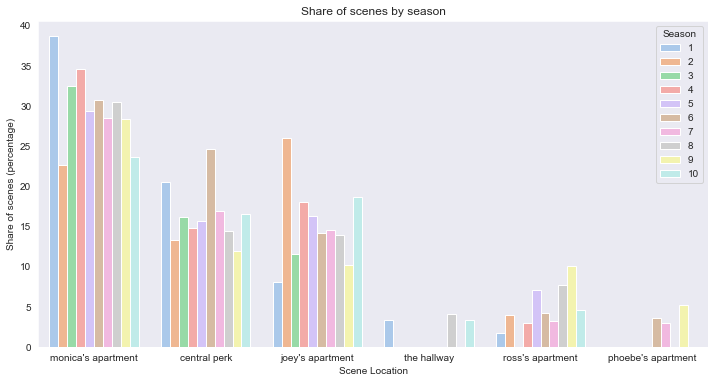

In [51]:
## Drawing the bar plot

fig, ax = plt.subplots(figsize=(12,6))

sns.barplot(data=scenes_pct_filtered, ax=ax, y='count', x='sceneGrp', hue='season', palette = "pastel");

plt.title('Share of scenes by season');
plt.xlabel('Scene Location');
plt.ylabel('Share of scenes (percentage)');

plt.legend(loc='upper right', title='Season');

It should be mentioned before starting that many scenes in season 2 could not be extracted properly. Therefore, the data here for season 2 might be misleading, and I will not take it into account.

Almost 40% of the scenes in season one were in Monica's apartment, but throughout the seasons the group was more open to new locations, and this rate dropped to around 25%. 

Central Perk remains stable around 15%, with only the 9th season below that. Joey's apartment share looks similar, but took a while to become popular with lower rates in the first season.

In the 9th season Central Perk and Joey's apartment both suffer from a drop in scenes share, while Ross's apartment and Phoebe's apartment rise. This is probably due to Emma being born and raised in Ross's apartment, and the plotline of Phoebe's relationship with Mike.

In season 10 the balance shifts back to the Central Park and Joey's apartment, also at the expanse of Monica's apartment, as Joey and Rachel's relationship is in the center.

#### Covnersation Characteristics

We figured out what are the most popular locations in the series, and it would be interesting to learn some more about the conversations in these locations. In this section, we will calculate first the median number of lines in each location. Then, we will find the median number of unique speakers in each location.

We take the median in both cases to reduce the impact of very long scenes or scenes with many characters (for example, in parties). 

In [52]:
lines_speaker_scenes = ep.groupby(['season', 'sceneGrp', 'episode_num']).agg({'sceneGrp': 'count', 'speaker': 'nunique'})
lines_speaker_scenes.columns=['lines_cnt', 'speaker_cnt']


avg_scenes = lines_speaker_scenes.groupby(['sceneGrp']).agg({'lines_cnt': 'median'}).sort_values(by='lines_cnt', ascending=False)
avg_speakers = lines_speaker_scenes.groupby(['sceneGrp']).agg({'speaker_cnt': 'median'}).sort_values(by='speaker_cnt', ascending=False)

top_scenes = scenes_pct_filtered['sceneGrp'].drop_duplicates().to_frame()

avg_scenes_top = top_scenes.merge(avg_scenes, on='sceneGrp', how='inner')
avg_spkrs_top = top_scenes.merge(avg_speakers, on='sceneGrp', how='inner')
avg_scenes_top

,sceneGrp,lines_cnt
0,monica's apartment,86.0
1,central perk,51.0
2,joey's apartment,39.0
3,the hallway,18.0
4,ross's apartment,23.0
5,phoebe's apartment,22.0


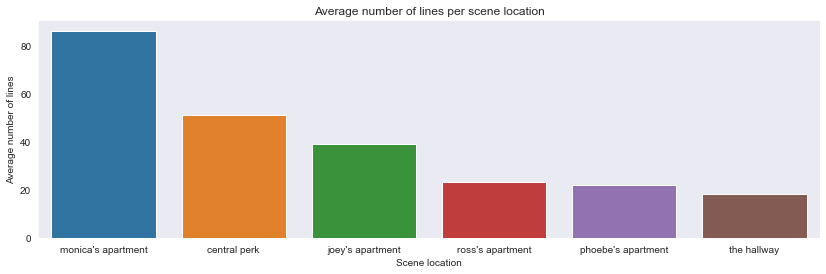

In [53]:
plt.figure(figsize=(14,4))
sns.barplot(data=avg_scenes_top.sort_values(by='lines_cnt', ascending=False), x='sceneGrp', y='lines_cnt');
plt.title('Average number of lines per scene location')
plt.xlabel('Scene location')
plt.ylabel('Average number of lines');

No big surprises, and no change in positions. However, we can see that despite Ross's apartment being more popular than Phoebe's, in terms of conversation length there's only a slight difference. Scenes at Phoebe's are usually longer.

Let's investigate another aspect of the conversations characteristics: how many unique speakers appear in each location? We will count the number of unique speakers in each location **per episode**. This means, how many different speakers appeared in this location throughout the episode.

In [54]:
avg_spkrs_top

,sceneGrp,speaker_cnt
0,monica's apartment,7.0
1,central perk,7.0
2,joey's apartment,4.0
3,the hallway,3.0
4,ross's apartment,3.0
5,phoebe's apartment,3.0


The median number of speakers in Monica's apartment and the Central Perk is 7. Taking in mind that the group only consists of 6 friends, this is rather surprising.

However, we should remember that the speaker name could be misleading: when the whole group is speaking together (for example, shouting "No!" together), the speaker will be recorded as "All". Same goes for cases when two or more characters speak together. 

Still, having more than 7 speakers for half of the times is surprising. We need to have a closer look at the distribution, to understand these numbers better.

We will draw the distribution of Monica's apartment and the Central Perk.

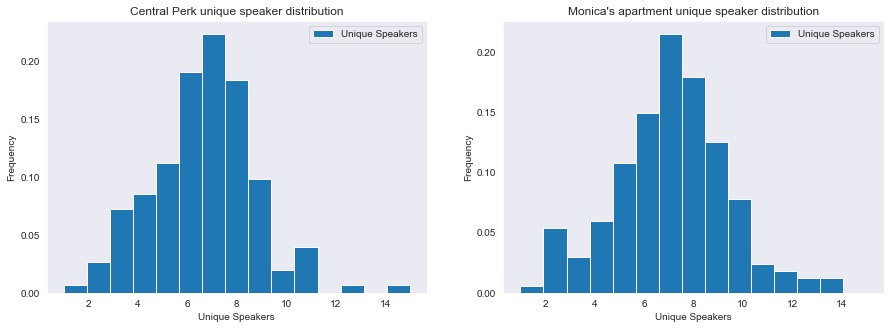

In [55]:
speakers_full = lines_speaker_scenes.reset_index()

speakers_dist = top_scenes.merge(speakers_full, on='sceneGrp', how='inner')[['sceneGrp', 'season', 'speaker_cnt']]

fig, ax = plt.subplots(1,2, figsize=(15,5))

speakers_dist.query('sceneGrp=="central perk"').plot(kind='hist', range=(1,15), bins=15, ax=ax[0], density=True);
speakers_dist.query('sceneGrp=="monica\'s apartment"').plot(kind='hist', range=(1,15), bins=15, ax=ax[1], density=True);

ax[0].set_title('Central Perk unique speaker distribution')
ax[1].set_title('Monica\'s apartment unique speaker distribution')

for i in range(0,2):
    ax[i].set_xlabel('Unique Speakers');
    ax[i].legend(labels=['Unique Speakers']);


The distribution shows that most frequently, both in Central Perk and Monica's apartment, the number of unique speakers was 7. Less specificly, the frequencies of 6 to 8 unique speakers are higher than other scenes.

This means that a large portion of the scense introduced more than just the 6 friends together. Let's try to understand who are those 1-2 additional characters to the 6 friends.

We will create a list of the 10 characters that apeared most times in each of our main locations.

In [56]:
## Create a list of most common speakers per scene location

##speakers_list = ep.groupby(['sceneGrp'])['speaker'].value_counts().to_frame()
speakers_list = ep.groupby(['sceneGrp', 'speaker', 'episode']).agg({'speaker': 'nunique'})
speakers_list.columns = ['count']
speakers_list = speakers_list.reset_index()
speakers_list = (speakers_list.groupby(['sceneGrp','speaker'])
                              .agg({'count': 'sum'})
                              .sort_values(by='count', ascending=False)
                              .reset_index())

## Merge with our list of top locations

top_speakers = top_scenes.merge(speakers_list, on='sceneGrp', how='inner')

## Get top 10 speakers per location

top_speakers.groupby('sceneGrp').head(10)

,sceneGrp,speaker,count
0,monica's apartment,Monica,177
1,monica's apartment,Chandler,170
2,monica's apartment,Rachel,152
3,monica's apartment,Phoebe,149
4,monica's apartment,Ross,144
5,monica's apartment,Joey,144
6,monica's apartment,All,60
7,monica's apartment,Mr. geller,9
8,monica's apartment,Monica and phoebe,8
9,monica's apartment,Monica and rachel,6


The answer to our mistery is hiding in this long table. As can be seen, in Monica's apartment, it is most likely that the 7th or 8th is a combination of two speakers, saying the same thing at the same time. In such cases, they will be mentioned together.

Let's make this table a little more readable by choosing only the top 6 rows - these will probably be the 6 friends.

In [57]:
top_speakers.groupby('sceneGrp').head(6)

,sceneGrp,speaker,count
0,monica's apartment,Monica,177
1,monica's apartment,Chandler,170
2,monica's apartment,Rachel,152
3,monica's apartment,Phoebe,149
4,monica's apartment,Ross,144
5,monica's apartment,Joey,144
222,central perk,Phoebe,144
223,central perk,Chandler,138
224,central perk,Ross,137
225,central perk,Joey,135


We see some interesting results. 
In Monica's apartment, for example, we can see that Joey had the same number of scenes as Ross, and less than Phoebe, even though Joey lived the entire 10 seasons right across the hall (and a short period in that Monica's apartment actually).

No hard feelings though, as Monica herself didn't spend much time in Joey's apartment, spending the same amount of times as Phoebe and less than Ross.

In the Central Perk, Phoebe spent more than any other character, while Monica and Rachel were probably too busy, and spent less time than the others at the Cafe.

The big surprise is in Phoebe's apartment. It was not a popular location for the group in general, but Mike managed to be the only character to kick out one of the 6 friends from the top 6. Actually, Mike, Ross and Chandler, who did not make it in the top 6, had the same number of scenes (3). Still, it's a remarkable achievement for Mike, and it says something about the friendship between Phoebe, Ross and Chandler.


### Group Relations

In this section, we will try to understand the strength of the relationships between the friends. We touched it a bit in the previous part on the level of scene locations, but we will try to dig deeper into what the characters said and who they spent time with.

#### Name Mentions
One way to understand relations between the group is to see how many times each character was mentioned by its friends. We will see who mentioned whom the most.

In [58]:
top_char = ep.speaker.value_counts().head(20).keys().to_list()
top_char.remove('All')

In [59]:
friends = ['Rachel', 'Ross', 'Chandler', 'Monica', 'Joey', 'Phoebe']

In [60]:
def findRelations(row):
    words = row.split(" ")
    for word in words:
        if word in top_char:
            return word

In [61]:
ep['relation'] = ep['text'].apply(findRelations)

In [62]:
relations = ep.groupby(['relation'])['speaker'].value_counts().to_frame()

In [63]:
ep['relation'].value_counts()

Ross        407
Joey        340
Monica      311
Rachel      307
Chandler    254
Phoebe      216
Emily        52
Mike         46
Carol        43
Richard      30
Janice       26
David        20
Charlie      17
Paul         11
Tag          10
Gunther       8
Amy           7
Name: relation, dtype: int64

In [64]:
ep

,speaker,text,scene,episode,season,episode_num,sceneGrp,relation
0,Monica,There's nothing to tell! He's just some guy I ...,central perk,101,1,01,central perk,None
1,Joey,"C'mon, you're going out with the guy! There's ...",central perk,101,1,01,central perk,None
2,Chandler,"All right Joey, be nice. So does he have a hu...",central perk,101,1,01,central perk,None
3,Phoebe,"Wait, does he eat chalk?",central perk,101,1,01,central perk,None
5,Phoebe,"Just, 'cause, I don't want her to go through w...",central perk,101,1,01,central perk,None
...,...,...,...,...,...,...,...,...
55797,Chandler,"Oh, it's gonna be okay.",monica and chandler's apartment,1017,10,17,monica's apartment,None
55799,Rachel,Do you guys have to go to the new house right...,monica and chandler's apartment,1017,10,17,monica's apartment,None
55800,Monica,We got some time.,monica and chandler's apartment,1017,10,17,monica's apartment,None
55801,Rachel,"Okay, should we get some coffee?",monica and chandler's apartment,1017,10,17,monica's apartment,None


In [65]:
with pd.option_context("display.min_rows", 200, "display.max_rows", 250, \
                       "display.max_columns", 3, 'display.max_colwidth', 3):
    display(relations)

speaker
relation speaker                                
Amy      Rachel                           5     
         Chip                             1     
         Joey                             1     
Carol    Ross                            24     
         Monica                           5     
         Chandler                         4     
         Rachel                           4     
         Phoebe                           3     
         Emily                            1     
         Minister                         1     
         Susan                            1     
Chandler Monica                          79     
         Ross                            41     
         Joey                            37     
         Phoebe                          37     
         Rachel                          22     
         Chandler                        16     
         Janice                           8     
         Joanna                           2     
         Mrs. bing                        2     
         Bandleader                       1     
         Frank jr.                        1     
         Gunther                          1     
         Mary-theresa                     1     
         Missy                            1     
         Ms. mckenna                      1     
         Richard                          1     
         Tom                              1     
         Transcribers note                1     
         Woman                            1     
Charlie  Ross                             6     
         Joey                             5     
         Chandler                         2     
         Rachel                           2     
         Benjamin                         1     
         Phoebe                           1     
David    Phoebe                           6     
         Chandler                         4     
         Monica                           4     
         Joey                             2     
         Emily                            1     
         Part 1 written by                1     
         Rachel                           1     
         Ross                             1     
Emily    Ross                            27     
         Rachel                          10     
         Monica                           6     
         Joey                             4     
         Chandler                         2     
         Phoebe                           2     
         Passenger                        1     
Gunther  Rachel                           4     
         Joey                             2     
         Ross                             1     
         The stripper                     1     
Janice   Chandler                        12     
         Ross                             4     
         Janice                           3     
         Phoebe                           3     
         Joey                             2     
         Monica                           1     
         Rachel                           1     
Joey     Rachel                          70     
         Chandler                        56     
         Monica                          43     
         Phoebe                          41     
         Ross                            41     
         Joey                            37     
         Charlie                          6     
         Kathy                            5     
         Donny                            4     
         Ginger                           2     
         Katie                            2     
         Lydia                            2     
         Mona                             2     
         Ronni                            2     
         Terry                            2     
         The director                     2     
         Announcer                        1     
         Bonnie                           1     
         Caitlin       

In [66]:
relations.columns = ['count']
relations = relations.reset_index()

In [67]:
relations.columns = ['speaker', 'relation', 'count']

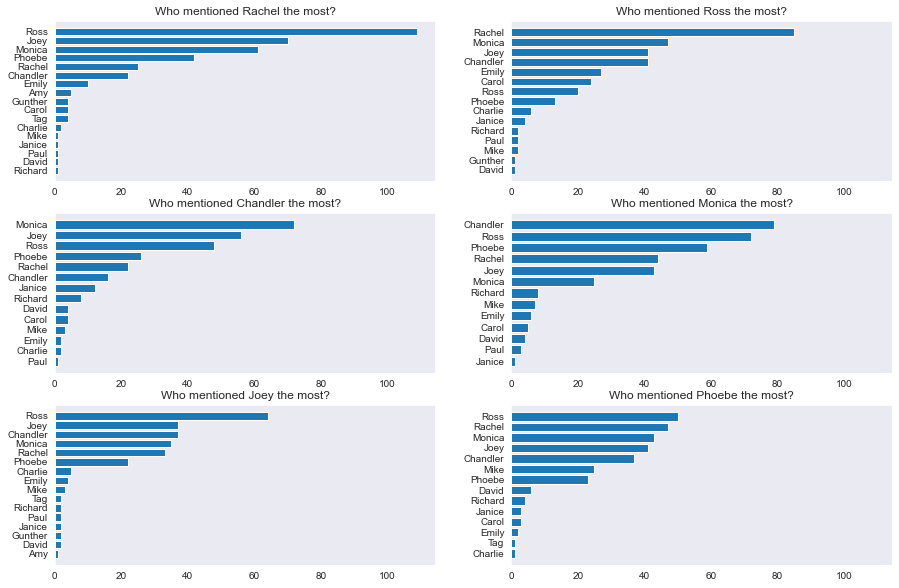

In [68]:

i = 0

fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,10), sharex=True)
for row in ax:
    for col in row:
        friend = friends[i]
        x = relations.query('relation == @friend').sort_values(by='count')['speaker']
        y = relations.query('relation == @friend').sort_values(by='count')['count']
        col.barh(x, y)
        col.xaxis.set_tick_params(labelbottom=True)
        i += 1
        col.title.set_text("Who mentioned {} the most?".format(friend));


#plt.legend().remove();
    

As expected, **Rachel** was mentioned the most by Ross, who mentioned her more than 100 times - no other characters enjoyed such attention. Look at Joey at second place - who beats Monica and Phoebe, Rachel's close friends. Chandler, however, probably had less interaction with Rachel - she mentioned her own name more than he did. 

**Ross** was mentioned most by Rachel (but far from the number of times he mentioned her). His sister, Monica, comes next and Joey and Chandler with the same number. Ross's ex-wives, Emily and Carol are next, and Phoebe is far behind.

Monica mentioned **Chandler** the most, then Joey and Ross only next. Phoebe comes next and Rachel is the last among the six friends, another evidence that the relationship between Chandler and Rachel was not the closest.

**Monica** was mentioned most by Chandler, then by Ross. In Third place, it might surprise some people, is Phoebe, who comes before Rachel. Joey comes last, but close to Rachel.

**Joey** was mentioned most by Ross. Joey himself comes next - he does get in touch with many new people, and perhaps had to present himself often. Chandler is next, then Monica. Rachel is only fourth, and Phoebe is last.

**Phoebe** was mentioned the most by Ross, only then by Rachel and Monica. Joey comes 4th and Chandler next.


To sum up, we can see evidence to the close relations of Ross and Rachel, and Chandler and Monica. 

Other than that, Ross and Monica maintaining good communication within the family. 

Other relations were not mutual: Joey mentioned Rachel much more than she mentioned him, Ross mentioned Phoebe more than she did, and so forth. 


#### Relations by Season

In [69]:
relations_season = ep.groupby(['relation', 'season'])['speaker'].value_counts().to_frame()
#relations_season = relations_season.head(6)
relations_season.columns = ['count']
relations_season = relations_season.reset_index()
relations_season.columns = ['speaker', 'season', 'relation', 'count']

In [70]:
relations_season.query('relation in @friends')

,speaker,season,relation,count
0,Amy,10,Rachel,2
1,Amy,3,Joey,1
2,Amy,4,Rachel,2
4,Amy,9,Rachel,1
5,Carol,1,Ross,14
...,...,...,...,...
621,Tag,7,Rachel,3
622,Tag,7,Joey,1
626,Tag,7,Phoebe,1
627,Tag,8,Joey,1


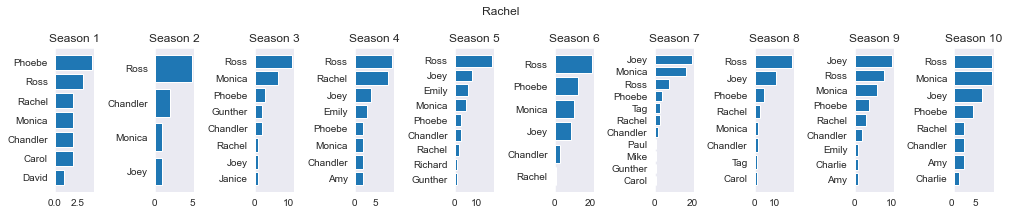

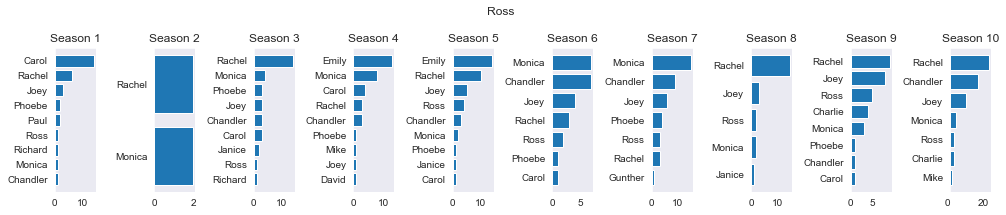

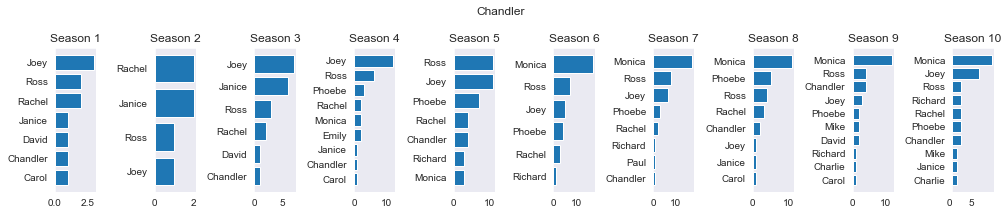

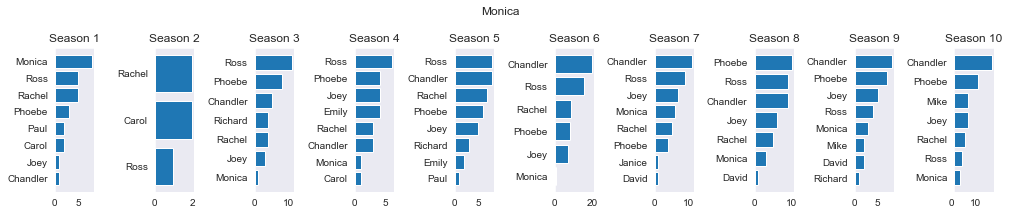

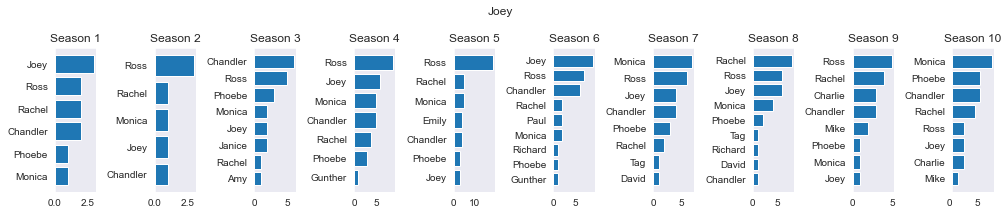

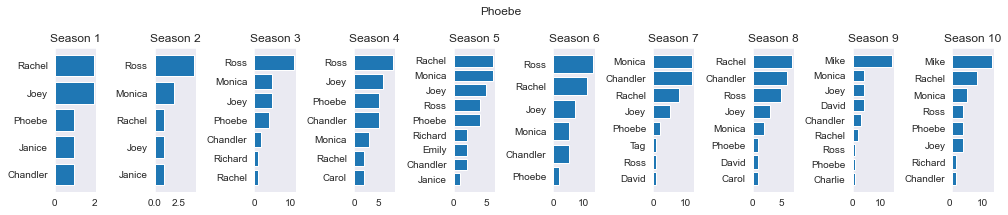

In [71]:
for friend in friends:
    i = "1"
    fig, ax = plt.subplots(nrows=1, ncols=10, figsize=(14,3))
    fig.suptitle(friend)
    for col in ax:
        x = relations_season.query('relation == @friend and season == @i').sort_values(by='count')['speaker']
        y = relations_season.query('relation == @friend and season == @i').sort_values(by='count')['count']
        col.barh(x, y)
        col.xaxis.set_tick_params(labelbottom=True)
        col.title.set_text("Season {}".format(i));
        i = str(int(i)+1)
    fig.tight_layout()
    plt.xticks(horizontalalignment="right")

The above charts show the change of the relationships whithin the group over the seasons. 

For **Rachel**, we can see that in the first season Phoebe was the closest one to her. Then, Ross mentioned her the most in the next 7 out of 9 season. Joey came first in seasons 7 and 9. 

For **Ross**, it varies significantly over the seasons. It starts with his first wife, Carol, in the first season. Then, Rachel captures the lead, until Emily joins the show in seasons 4 and 5. Monica is dominant in seasons 6-7, and then Rachel returns from seasons 8 to 10. 

For **Chandler**, the closest friend is Joey in the first seasons, while on season 5 Ross comes first by a small margin over Joey. However, since season 6 Monica takes the lead.

For **Monica**, mainly Ross is dominant in the first seasons. Then, from season 6, it is Chandler. However, in season 8 Phoebe takes the lead, with Chandler coming only third.

For **Joey**, Ross and Chandler are closest in the first seasons. Monica is the closest character in seasons 7 and 10, while Rachel is only dominant in season 8. Interestingly, Phoebe is not first in any of the seasons.

For **Phoebe**, Rachel and Ross are mostly dominant (with an advantage to Ross). Monica takes the lead in season 7. In seasons 9 to 10, it is Mike who is closest.

#### Shared Scenes

In this section, we will group different speakers who appear together in each scene. Then, we will count the number of times each group of people recurs in the dataset. This way, we will be able to tell which characters appear together the most.

In [72]:
## Get the names of different speakers in each episode and scene

sp_sce = ep.groupby(['episode', 'sceneGrp', 'speaker']).max().sort_values(by='speaker')

<ipython-input-72-d1351a5b391c>:3: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  sp_sce = ep.groupby(['episode', 'sceneGrp', 'speaker']).max().sort_values(by='speaker')


In [73]:
## Reset index and leave only episode, scene and speaker

speakers_grouped = sp_sce.reset_index()[['episode', 'sceneGrp', 'speaker']]

In [74]:
## Remove lines where speaker is `All` (refferring to lines said by the all participants together)

speakers_grouped = speakers_grouped.drop(speakers_grouped[speakers_grouped['speaker']=='All'].index)

In [75]:
## Order by episode, scene and most importantly - speaker. 
## This way, we make sure that we only have one indication to each set of characters.

speakers_grouped = speakers_grouped.sort_values(by=['episode', 'sceneGrp', 'speaker'])

## Join different speakers per episode and scene to one column, separated by a comma

speakers_grouped['speakers'] = speakers_grouped.groupby(['episode', 'sceneGrp'])['speaker'].transform(lambda x: ','.join(x))

In [76]:
speakers_grouped[['episode', 'sceneGrp', 'speakers']]

,episode,sceneGrp,speakers
287,1001,barbados,"Both,Chandler,Charlie,Joey,Joeys voice, but sh..."
1029,1001,barbados,"Both,Chandler,Charlie,Joey,Joeys voice, but sh..."
1110,1001,barbados,"Both,Chandler,Charlie,Joey,Joeys voice, but sh..."
2135,1001,barbados,"Both,Chandler,Charlie,Joey,Joeys voice, but sh..."
2391,1001,barbados,"Both,Chandler,Charlie,Joey,Joeys voice, but sh..."
...,...,...,...
1185,923,the restaurant,"Chandler,David,Mike,Monica,Phoebe"
2613,923,the restaurant,"Chandler,David,Mike,Monica,Phoebe"
2969,923,the restaurant,"Chandler,David,Mike,Monica,Phoebe"
3879,923,the restaurant,"Chandler,David,Mike,Monica,Phoebe"


In [77]:
## Leave only one row for each different scene

speakers_grp_undup = speakers_grouped[['episode', 'sceneGrp', 'speakers']].drop_duplicates()

In [78]:
## See how many times each set appears in the dataset.

shared_scenes = speakers_grp_undup['speakers'].value_counts().head(10)

In [79]:
shared_scenes

Chandler,Joey,Monica,Phoebe,Rachel,Ross    57
Rachel,Ross                                31
Chandler,Monica                            23
Chandler,Joey                              15
Phoebe,Rachel                              13
Chandler,Joey,Monica,Phoebe,Rachel         12
Ross                                       10
Phoebe,Rachel,Ross                         10
Chandler,Joey,Ross                         10
Chandler,Joey,Monica                       10
Name: speakers, dtype: int64

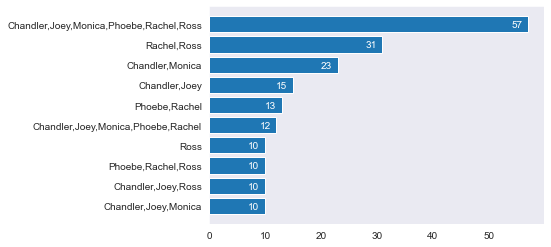

In [80]:
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(y[i]-2, i+0.15 ,y[i], ha = 'center', color='white')
x = shared_scenes.index
y = shared_scenes.values
plt.barh(x, y);
plt.gca().invert_yaxis();
addlabels(x, y)

The largest number of scenes includes the whole group - 57 scenes, a number almost twice as high as the second largest. 

Next, most scenes are dedicated to the two couples within the group: Rachel and Ross with 31 scenes, and not far behind Chandler and Monica with 23.

Two pairs of friends come next - Chandler and Joey (15), and Phoebe and Rachel (13). We get an important information here about the stronger pairs of friends. 

12 scenes involved the whole group except Ross. However, Ross gets compensated with 10 scenes where he appears all alone. This suggest that Ross, in a way, is a bit distant from the rest of the group, but still gets a lot of screen time by himself.

It is worth mentioning that scenes where two or more characters spoke together were registered differently, so there is some adventage in this list for scenes with 1-2 speakers where it is unlikely to occur.

### Fields of Interest

In this section, we will try to map the subjects that each character was mostly interested in. We will try to understand which words and subjects appeared the most in what they said.

We will use the dataframe `words` that we created earlier.

In [81]:
## Convert the words to lowercase

words['word'] = words['word'].str.lower()

In [82]:
words.head()

,speaker,word,scene,episode,season,episode_num
0,Monica,theres,central perk,101,1,01
1,Monica,nothing,central perk,101,1,01
2,Monica,to,central perk,101,1,01
3,Monica,tell,central perk,101,1,01
4,Monica,hes,central perk,101,1,01


In [83]:
def lemmatize(row):
    return wordnet_lemma.lemmatize(row, pos = 'n')

words['lemma'] = words['word'].apply(lemmatize)

#### Word Clouds

Word clouds are a visualization of the most common words said by the characters. They will help us get an idea of the most common words and subjects said by each friend. We will create a word cloud of the whole show, then compare word clouds of the friends and of different seasons.

In [84]:
word_list = words['word']
text = ' '.join(word_list)

stop_words = set(STOPWORDS)
#stop_words = set(stopwords.words('english'))
stop_words.update(['oh', 'well', 'yeah', 'uh', 'thats', 'gonna', 'really',
                   'umm', 'ive','theres', 'theyre', 'hey'])

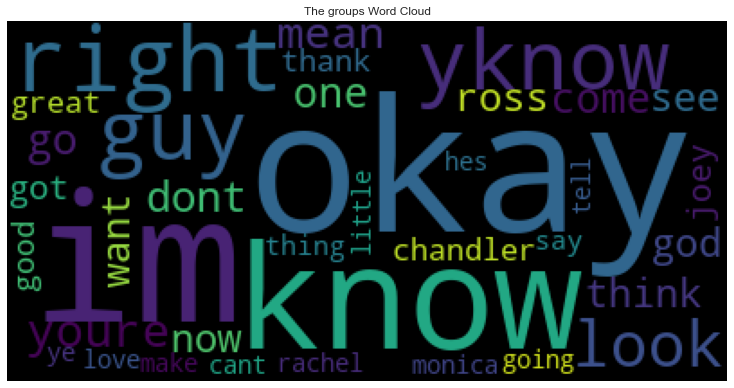

In [85]:
wordcloud = WordCloud( 
            background_color ='black', 
            stopwords = stop_words, 
            min_font_size = 10).generate(text)
plt.figure(figsize = (10, 10), facecolor = None) 
plt.title("The groups Word Cloud")
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

From a first glance, positive words are more popular. Words like "okay", "right" are dominant, while negative words like "can't" and "don't" are as popular as the positive words "good", "great". All friends names are also dominant, with ross a little more than the rest.

There's a lot of discussion of the group about themselves ("our"), and many conversations on second-person ("you're") over third-person (that is not in the list).

We can also see a reflection of the main topics of the show: forgiveness ("sorry"), love and desires ("want"). 

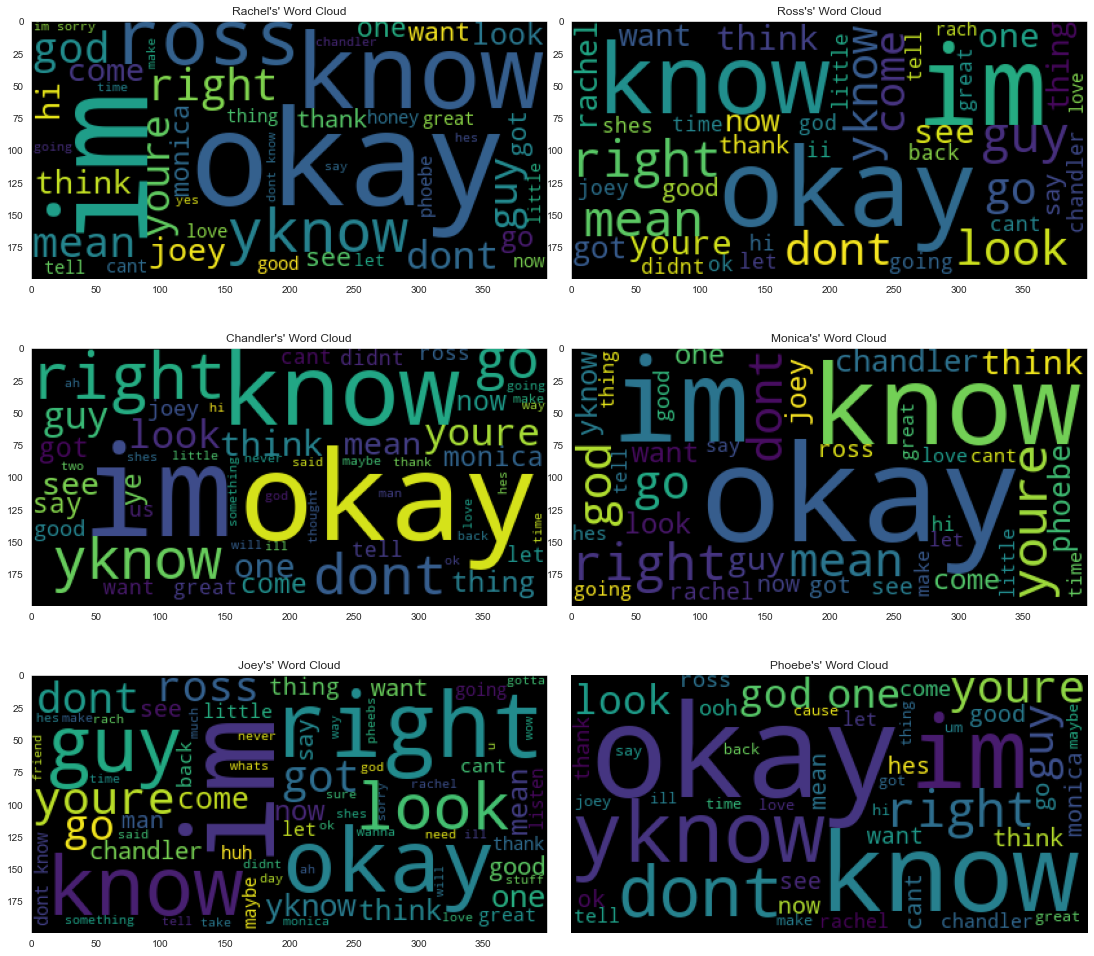

In [86]:
   
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,15))
i = 0
for row in ax:
    for col in row:
        friend = friends[i]
        word_list = words.query('speaker == @friend')['word']
        text = ' '.join(word_list)
        wordcloud = WordCloud( 
                    background_color ='black', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(text)
        #plt.figure(figsize = (7, 7), facecolor = None) 
        col.set_title("{}'s' Word Cloud".format(friend))
        col.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        i+=1
plt.show()

For **Rachel**, we can instantly see that Ross is a dominant topic, while it is not as dominant in Ross's cloud. 

Between **Monica and Chandler**, Chandler doesn't really talk about love, unlike Monica, but he is speaking about "us" - hopefully he refers to him and Monica. 

For **Joey and Phoebe**, the word "I'm" is less dominant, suggesting that the show might be a bit less centered around their lives.

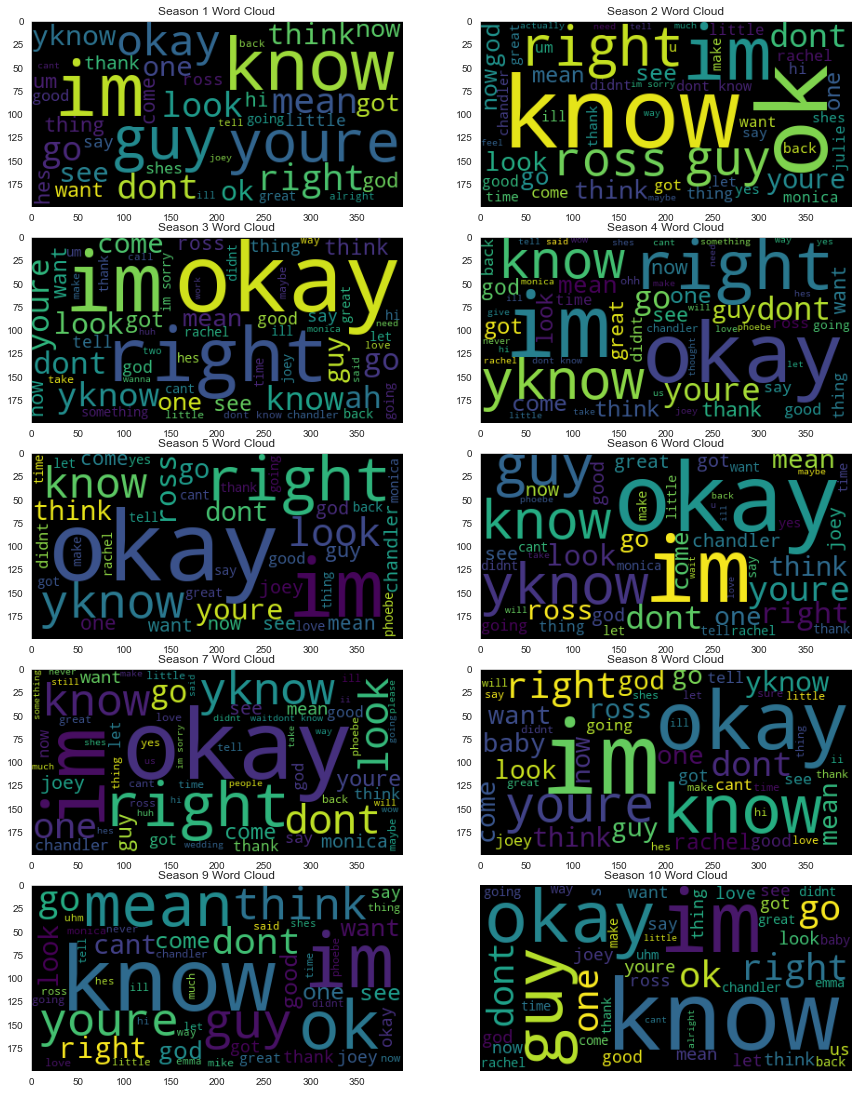

In [87]:
fig, ax = plt.subplots(nrows=5, ncols=2, figsize=(15,15))
i = 1
for row in ax:
    for col in row:
        season = str(i)
        word_list = words.query('season == @season')['word']
        text = ' '.join(word_list)
        wordcloud = WordCloud(
                    background_color ='black', 
                    stopwords = stop_words, 
                    min_font_size = 10).generate(text)
        #plt.figure(figsize = (7, 7), facecolor = None) 
        col.set_title("Season {} Word Cloud".format(season))
        col.imshow(wordcloud) 
        plt.axis("off") 
        plt.tight_layout(pad = 0) 
        i+=1
plt.show()

The word clouds of the seasons are pretty similar, but still we can find some interesting differences. 

For example, the word "okay" is less dominant in seasons 1 and 9 - this could be merely due to a more frequent use in the shorter version, "ok", that can be seen in both word clouds.

however, he word "mean" and "think" is more dominant in season 9 - perhaps the group was busier in deliberation.

Positive words as "good" and "great" are more dominant in seasons 5-6 than in the first or last seasons. This could shed some light over the mood of the group during these seasons.

#### Sentiment Analysis

In this section, we will use TextBlob to get a sentiment analysis of the characters lines. The sentiment will provide an assesment of how positive\negative the sentence is on a scale of -1 (most negative) to 1 (most positive). This method is using the occurance of words with positive\negative conotation.

In [88]:
## For each line, calculate a sentiment rate

ep['sentiment'] = ep['text'].apply(lambda text: TextBlob(text).sentiment.polarity)

In [89]:
## Many lines are neutral - they got a sentiment rate of 0

ep.sentiment.describe()

count    51624.000000
mean         0.091265
std          0.283343
min         -1.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.000000
Name: sentiment, dtype: float64

##### Change in Sentiment Over Time

In this section, we will present the change in average sentiment for each character over different seasons.

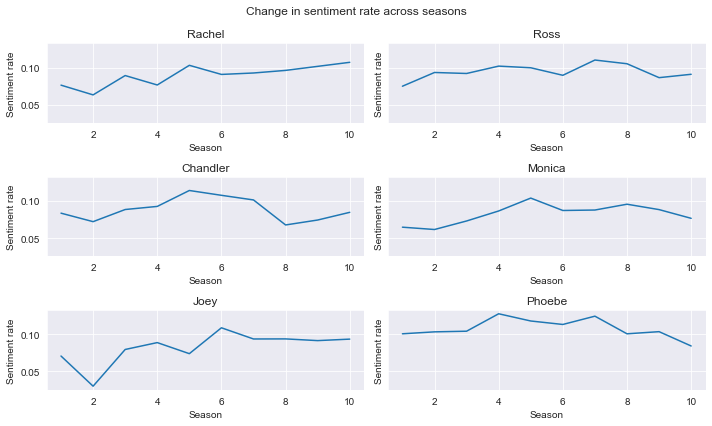

In [90]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(10,6), sharey=True)
i=0
for row in ax:
    for col in row:
        friend = friends[i]
        data = ep.query('speaker == @friend')
        group = data.groupby('season')['sentiment'].mean()
        group = group.reset_index()
        group['season'] = group['season'].astype(int)
        group = group.sort_values(by='season')
        col.plot(group['season'], group['sentiment'], label=friend)
        col.set_title(friend)
        col.set_xlabel("Season")
        col.grid()
        col.set_ylabel("Sentiment rate")
        i+=1
plt.suptitle("Change in sentiment rate across seasons")
plt.tight_layout()

First of all, our friends maintain a positive average. We do see some change in their levels. Rachel sarts not very positive, but constantly raises their levels until the end of the show. Ross, however, reaches a peak at season 7, and then his rates go down a bit.

Chandler had his peak at season 5, but then it started dropping again. Monica was more stable, also peaking on season 5, with lower rates in the first and last seasons.

Joey started lower, then peaked in season 6 and maintained relatively high rates. Phoebe had an opposite course with high rates until season 9, then going down a little in season 10.

#####  Most Positive Characters

In this part, we will examine the highest sentiment rates among the top 20 characters (those who had most lines).

In [91]:
highest_sentiment = ep.query('speaker in @top_char').groupby('speaker')['sentiment'].mean().sort_values(ascending=False).head()

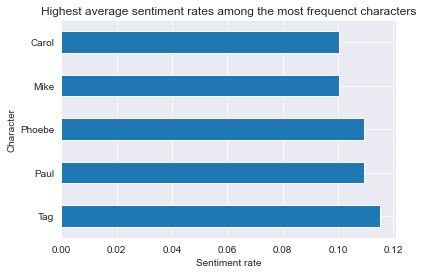

In [92]:
highest_sentiment.plot(kind='barh', grid=True);
plt.title("Highest average sentiment rates among the most frequenct characters")
plt.xlabel("Sentiment rate")
plt.ylabel("Character");

Tag has the highest sentiment rate - perhaps this is due to his young age? Paul, who dated Rachel for a while, is second. This interesting due to his interesting relationship with Ross (who dated his student daughter), but maybe he was trying hard enough to be nice around Rachel and his daughter.

Phoebe is the only representation for the 6 friends, followed by her husband, Mike, who make together a very positive couple. Carol, Ross's ex-wife is next, and shows that you probably get more positive when you follow your heart.

#####  Most Positive Characters

Next, we will compare the sentiment rate among the 6 friends in all seasons together.

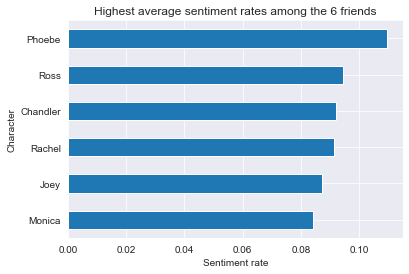

In [93]:
highest_sentiment_friends = ep.query('speaker in @friends').groupby('speaker')['sentiment'].mean().sort_values()
highest_sentiment_friends.plot(kind='barh', grid=True);
plt.title("Highest average sentiment rates among the 6 friends")
plt.xlabel("Sentiment rate")
plt.ylabel("Character");

Among the friends, Phoebe has the highest average sentiment of over 0.1. Monica is the least positive character with only a bit more than 0.08. 

#### Text Classification

In this section, we will use gensim library and tf-idf method to compare the corpuses of the 6 friends to one another. This process will provide a rate of similarity between the words that each pair of characters said. As the similarity rate goes higher, we can conclude that this pair spoke about similar issues.

We will analyze four aspects:
1. Friend-to-friend, for the whole series.
2. All friends together, season-to-season.
3. Friend-to-friend, season-to-season.
4. Friend to whole groups, over different seasons.

##### Friend-to-Friend Analysis (All seasons)

In this part, we will create a corpus for each friends that will include the lemmatized words they said during all seasons. We will compare this corpus to those of other friends.

In [94]:
## Create a corpus that will include the corpuses of all friends

corpus = {}
for friend in friends:
    corpus[friend] = words.query('speaker == @friend')['lemma'].to_list()

## Create a dictionary that includes words from all corpuses
documents = [corpus[x] for x in friends]
dictionary = Dictionary(documents)

## Create a bag of words presentation for each friend

bow = {}
for friend in friends:
    bow[friend] = dictionary.doc2bow(corpus[friend]) 

## Group all bag of words together
    
bows = [bow[x] for x in friends]

## Calculate tf-idf rates for each friend

tfidf = TfidfModel(bows)

tfidf_rate = {}
for friend in friends:
    tfidf_rate[friend] = tfidf[bow[friend]] 


In [95]:
## Use the glove-twitter-25 api as our model

model = api.load('glove-twitter-25')

In [96]:
## Calculate similarities

termsim_index = WordEmbeddingSimilarityIndex(model)
termsim_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary, tfidf)

100%|████████████████████████████████████████████████████████████████████████████| 14294/14294 [07:33<00:00, 31.53it/s]


In [97]:
## Create a dataframe to store friend-to-friend similarities

friend_t_friend_similarities = pd.DataFrame(index=friends)

In [100]:
## Store tf-idf rates for each friend against another

for friend_column in friends:
    similarities_list = []
    for friend_against in friends:
        similarities_list.append(termsim_matrix.inner_product(tfidf_rate[friend_column], tfidf_rate[friend_against], normalized=(True, True)))
    friend_t_friend_similarities[friend_column] = similarities_list

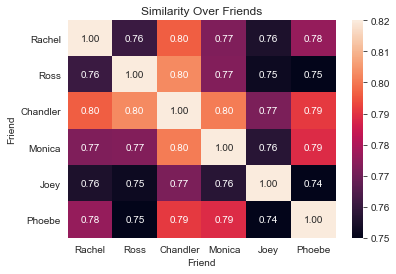

In [101]:
## Draw a heatmap

sns.heatmap(friend_t_friend_similarities, annot=True, fmt=".2f", vmin=0.75, vmax=0.82);
plt.title("Similarity Over Friends");
plt.xlabel("Friend");
plt.ylabel("Friend");

Basically, all character share quite a high similarity between 0.74 to 0.8. However, Chandler, Ross, Rachel and Monica share a higher similarity rate (0.8) with one another.
Phoebe has a slightly lower rate with Chandler, Monica (0.79) and Rachel (0.78), and and even lower rate with Ross (0.75 and Joey (0.74).

Joey has a relatively lower similarity rate than the rest of the group - 0.74 to 0.76, with a top value of 0.77 with Chandler.

##### Season-to-Season analysis (All Friends)

We will do the same process, but now we will compare corpuses of all friends together over the different seasons.

In [102]:
corpus = {}
for season in range(1,11):
    season_str = str(season)
    corpus[season] = words.query('season == @season_str')['lemma'].to_list()
    
documents = [corpus[season] for season in range(1,11)]
dictionary = Dictionary(documents)

bow = {}
for season in range(1,11):
    bow[season] = dictionary.doc2bow(corpus[season]) 
    
bows = [bow[season] for season in range(1,11)]
tfidf = TfidfModel(bows)

tfidf_rate = {}
for season in range(1,11):
    tfidf_rate[season] = tfidf[bow[season]] 


In [103]:
termsim_index = WordEmbeddingSimilarityIndex(model)
termsim_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary, tfidf)

100%|████████████████████████████████████████████████████████████████████████████| 15822/15822 [08:23<00:00, 31.45it/s]


In [104]:
seasons = range(1,11)
similarities_seasons = pd.DataFrame(index=seasons)

for season_column in range(1,11):
    similarities_list = []
    for season_against in range(1,11):
        similarities_list.append(termsim_matrix.inner_product(tfidf_rate[season_column], tfidf_rate[season_against], normalized=(True, True)))
    similarities_seasons[season_column] = similarities_list

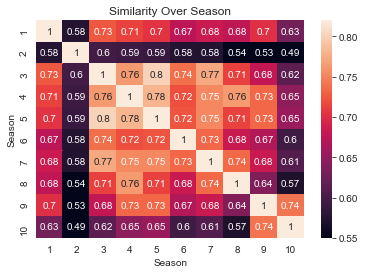

In [105]:
sns.heatmap(similarities_seasons, annot=True, vmin=0.55, vmax=0.82);
plt.title("Similarity Over Season");
plt.xlabel("Season");
plt.ylabel("Season");

We can see some groups of similar seasons. The first season has a relatively low similarity to other seasons. The second season is much lower - but this is due to partial data for this season. Seasons 3-5 are very similar, and share the highest similarity rates.

Then seasons 6-8 are somewhat similar to their predecessors, but not at the same ratess, especially season 6, which seems quite unique. 

Season 9 is quite similar to seasons 4-5, but a bit more similar to season 10. However, season 10 is only similar to season 10.

We can identify 4 groups of seasons:
1. Season 1.
2. Seasons 3-5.
3. Seasons 6-8 (Also have relatively high similarity to seasons 3-5).
4. Seasons 9-10.

##### Friend-to-Friend, Season-to-Season Analysis

We will now combine both filters to one analysis. We will separate the corpuses per friend **and** season, to see which pair of friends corpuses were similar and on which seasons.

In [106]:
corpus = {friend: {} for friend in friends}
for friend in friends:
    for season in range(1,11):
        season_str = str(season)
        corpus[friend][season] = words.query('season == @season_str and speaker == @friend')['lemma'].to_list()
    
documents = []
for friend in friends:
    for season in range(1,11):
        documents.append(corpus[friend][season])
dictionary = Dictionary(documents)

bow = {friend: {} for friend in friends}
for friend in friends:
    for season in range(1,11):
        bow[friend][season] = dictionary.doc2bow(corpus[friend][season]) 
    
bows = []
for friend in friends:
    for season in range(1,11):
        bows.append(bow[friend][season])
tfidf = TfidfModel(bows)

tfidf_rate = {friend: {} for friend in friends}
for friend in friends:
    for season in range(1,11):
        tfidf_rate[friend][season] = tfidf[bow[friend][season]] 


In [107]:
termsim_index = WordEmbeddingSimilarityIndex(model)
termsim_matrix = SparseTermSimilarityMatrix(termsim_index, dictionary, tfidf)

100%|████████████████████████████████████████████████████████████████████████████| 14294/14294 [07:40<00:00, 31.02it/s]


In [108]:
iterables = [[friend for friend in friends],[season for season in seasons]]
index = pd.MultiIndex.from_product(iterables, names=["speaker", "season"])

In [109]:
seasons = range(1,11)
similarities_seasons_friends = pd.DataFrame(index=index, columns=index)
for friend_column in friends:
    for season_column in range(1,11):
        similarities_list = []
        for friend_against in friends:
            for season_against in range(1,11):
                similarities_list.append(termsim_matrix.inner_product(tfidf_rate[friend_column][season_column], tfidf_rate[friend_against][season_against], normalized=(True, True)))
        #similarities_seasons_friends[friend_column][season_column] = similarities_list
        similarities_seasons_friends.loc[:,(friend_column,season_column)] = similarities_list

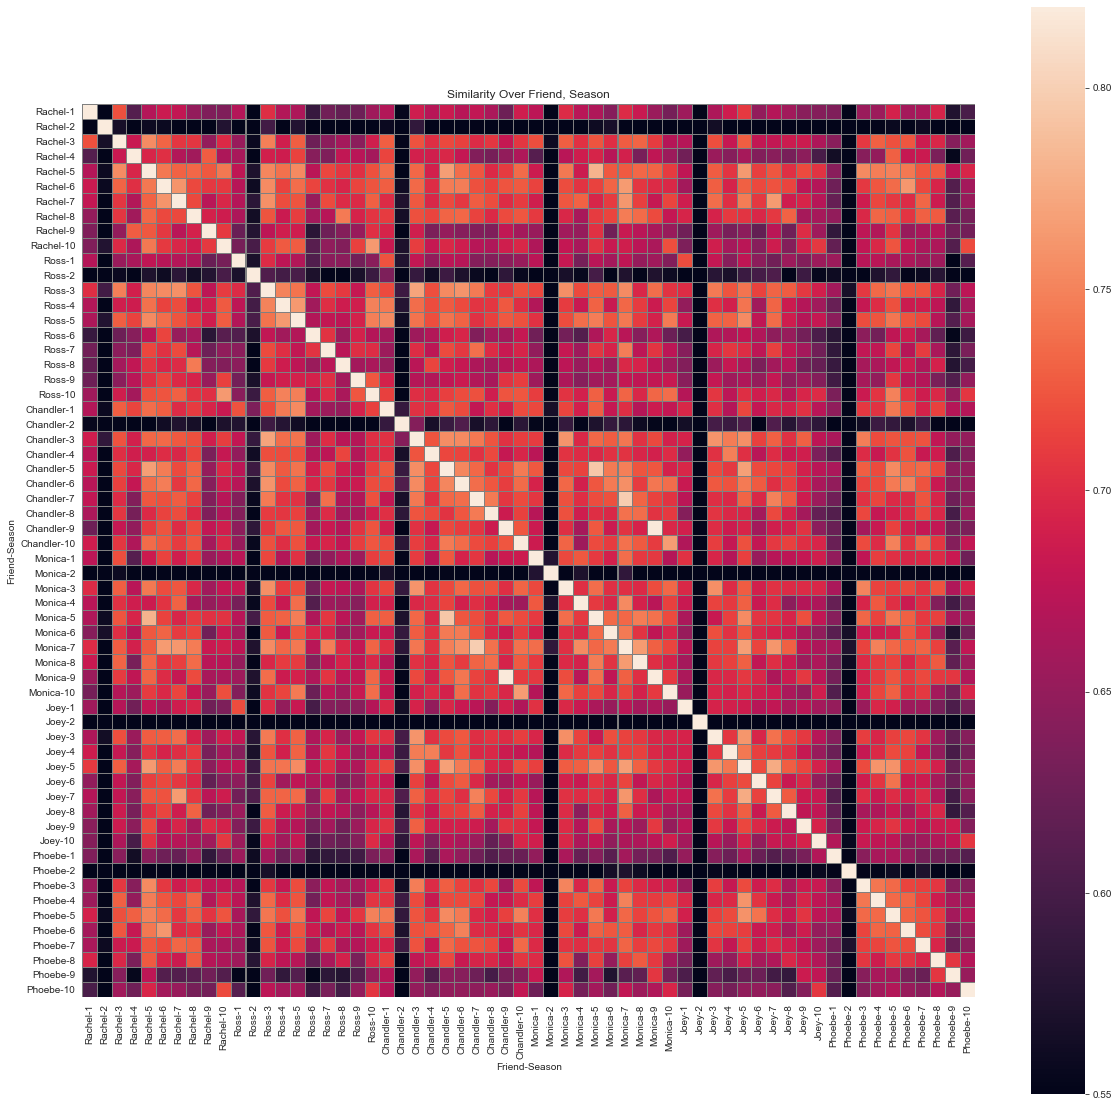

In [110]:
plt.figure(figsize=(20,20))
sns.heatmap(similarities_seasons_friends, vmin=0.55, vmax=0.82, square=True, linewidths=0.04, linecolor='gray');
plt.title("Similarity Over Friend, Season");
plt.xlabel("Friend-Season");
plt.ylabel("Friend-Season");

We can easily spot the highest similarities between characters and seasons:
1. Monica and Chandler had a very high similarity in season 9, and relatively high similarity rate sinces season 5. This is the season they started having their relationship.

2. Chandler and Joey had a relatively high similarity in seasons 3-5. 

3. Monica and Rachel had high similarity rate in season 5. 

4. Ross and Rachel had their highest similarity rate in season 10, when they were finally together and raising a baby. 

5. Joey and Rachel had their highest similarity rates in season 7 and season 5, even before they tried dating. They actually had lower similarity rates as their relationship scaled up in season 8. This is part of a wider phenomena.

6. Some characters seperated from each other in the last seasons. See Rachel, for example, that has lower similarity rates in seasons 9-10 with the whole group except Ross. The same happens to Joey and Phoebe. Ross, however, was lost between seasons 6 to 9 from everyone but Rachel.

We can also see how each character changed over the seasons compared to itself:

1. Chandler and Monica did not change much over the years. 
2. Phoebe stayed the same for 8 seasons, then changed significantly. 
3. Rachel and Joey did change.
4. Ross changed during seasons 6-9, then in the final season got closer to the first seasons.

##### Average Similarity Over Seasons

We will now calculate the average similarity of each friend to all other friends, and see how it changes across the different seasons.

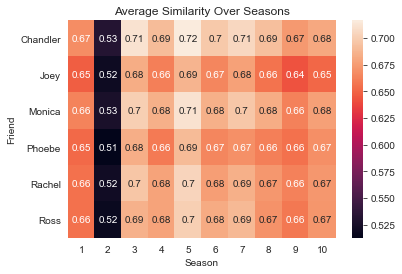

In [111]:
similarities_average = similarities_seasons_friends.groupby('speaker').mean().T

sns.heatmap(similarities_average.groupby('season').mean().T, annot=True);
plt.title("Average Similarity Over Seasons");
plt.xlabel("Season");
plt.ylabel("Friend");

We can see the similarity rates growing up from season 1 to a peak at season 5. The group converged around the same subject in Season 5, with Joey and Phoebe yet again a little bit behind along the way. In Joey's case, this might be due to his lack of serios relationships, while Phoebe has always been a little bit of an outsider.

Anyway, starting from season 6, it seems that each character (or pair of characters, if we add information from the previous sections) slowly went apart. In Season 9, for example, the similarity was as low as season 1. Towards the end of the show, in the season 10, the group seems to get a little bit more similar.

##### Conclusions

The classification of the characters texts provided us with information about the course that the friends took over the shows seasons.

Overall, Phoebe and Joey have less similarity rates with the the group.

We can divide the seasons into 3-4 groups with different characteristics. 
In **Season 1**, similarities between the friends are lower. Each one comes from a different stage, they don't know each other well enough, and it shows.

In **seasons 3-5** the group gets closer. Similarity rates peak at season 5, where the group is concerned about the same issues. The 3 boys and 3 girls have their highest rates of similarity among themselves as well.

In **seasons 6-8** the situation yet to change much, but the group starts dividing into different paths. Two couples - Ross and Rachel, Chandler and Monica get closer.

**Seasons 9-10** are different than the previous seasons. Joey and Phoebe get even more distant, with Phoebe also getting less similar to her younger self. Rachel also turned less similar than the group, remaining with high similar rates only to Ross. 